In [1]:
!pip install shap
!pip install lime

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import shap
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv("xai.csv", index_col=False)
df.drop(axis=1, labels='Unnamed: 0', inplace=True)

X = df.iloc[:, 0:256]
y = df.Class

num_classes = len(np.unique(y))

encoder = LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)
y = np_utils.to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(256,)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, verbose=0)


In [8]:
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       114
           1       0.67      0.74      0.70       208
           2       0.68      0.54      0.60       219
           3       0.49      0.19      0.27       105
           4       0.88      0.88      0.88       785
           5       0.56      0.42      0.48       197
           6       0.78      0.85      0.81        66
           7       0.69      0.82      0.75       767
           8       0.23      0.31      0.27        55
           9       0.50      0.44      0.47       180
          10       0.78      0.89      0.83       121
          11       0.87      0.83      0.85       602
          12       0.85      0.78      0.81       131
          13       0.73      0.71      0.72        92

    accuracy                           0.75      3642
   macro avg       0.68      0.67      0.67      3642
weighted avg       0.75      0.75      0.74      3642



In [9]:
explainer = shap.Explainer(model, X_train.values, algorithm="permutation", max_evals=1000)
shap_values = explainer(X_test.values)


Permutation explainer: 3643it [08:07,  7.37it/s]                                                                       


In [10]:
mean_abs_shap_values = np.mean(np.abs(shap_values.values), axis=(0, 2))  # Aggregate across axis 0 (features) and axis 2 (classes)

feature_names = [f"{X.columns[i]}" for i in range(256)]

sorted_feature_importances = sorted(enumerate(mean_abs_shap_values), key=lambda x: x[1], reverse=True)
top_10_negative_features = sorted_feature_importances[:10]

negative_impacting_features = []

print("Top 10 Features with Negative Impact on the Model:")
for feature_idx, importance in top_10_negative_features:
    negative_impacting_features.append(feature_names[feature_idx])
    print(f"{feature_names[feature_idx]} - {importance:.4f}")

Top 10 Features with Negative Impact on the Model:
0 - 0.0216
20 - 0.0188
3c - 0.0136
65 - 0.0132
61 - 0.0119
0a - 0.0115
69 - 0.0109
74 - 0.0105
73 - 0.0093
3e - 0.0089


In [11]:
print(negative_impacting_features)

['0', '20', '3c', '65', '61', '0a', '69', '74', '73', '3e']


In [13]:
new_X = X.drop(negative_impacting_features, axis=1)
new_X.head()

,1,2,3,4,5,6,7,8,9,0b,...,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(246,)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, verbose=0)


In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       114
           1       0.57      0.56      0.56       208
           2       0.62      0.68      0.65       219
           3       0.39      0.18      0.25       105
           4       0.81      0.84      0.82       785
           5       0.43      0.45      0.44       197
           6       0.75      0.77      0.76        66
           7       0.71      0.71      0.71       767
           8       0.53      0.33      0.40        55
           9       0.41      0.48      0.44       180
          10       0.85      0.85      0.85       121
          11       0.80      0.79      0.79       602
          12       0.83      0.69      0.76       131
          13       0.63      0.67      0.65        92

    accuracy                           0.71      3642
   macro avg       0.66      0.64      0.64      3642
weighted avg       0.70      0.71      0.70      3642



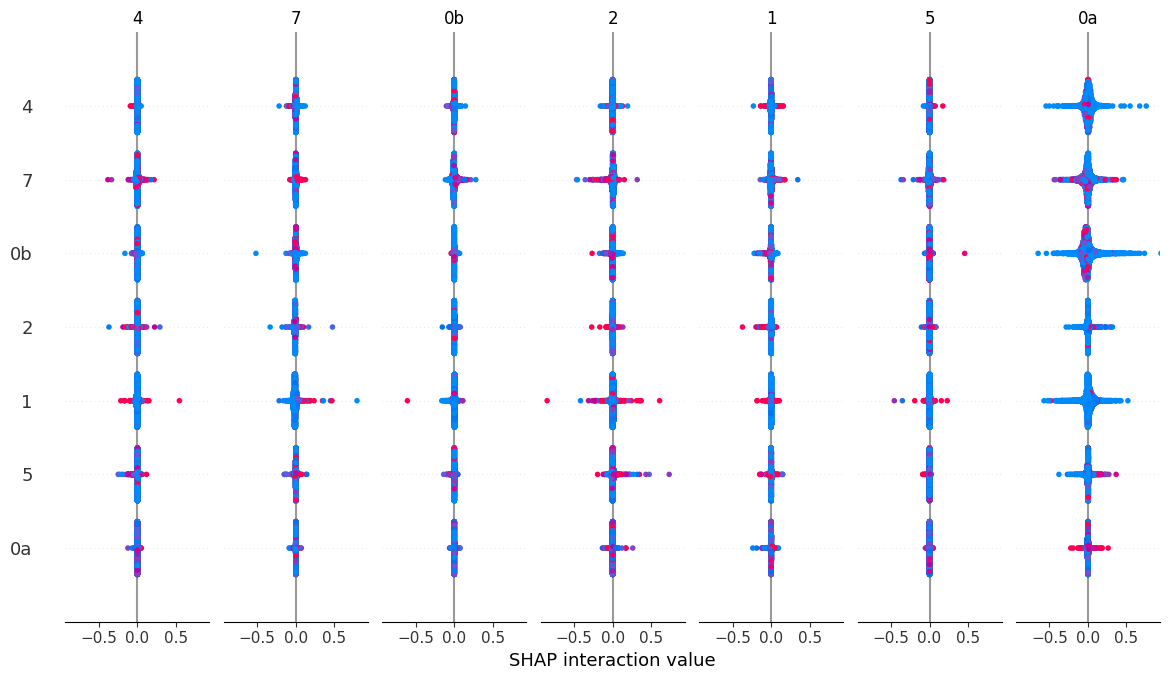

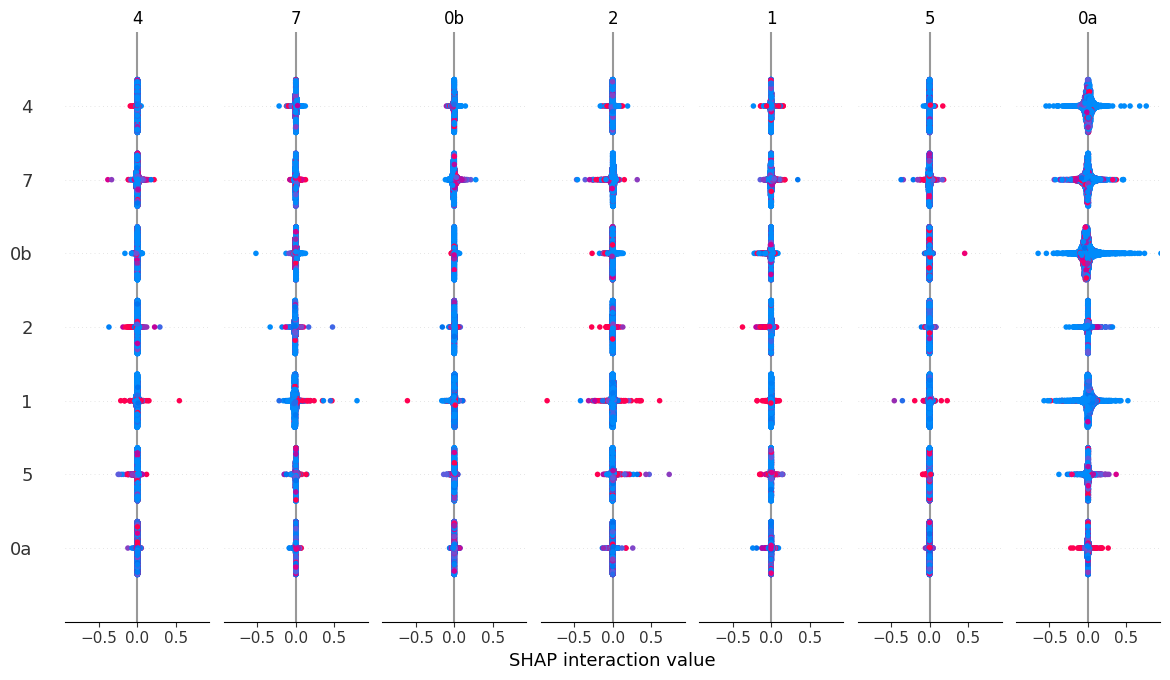

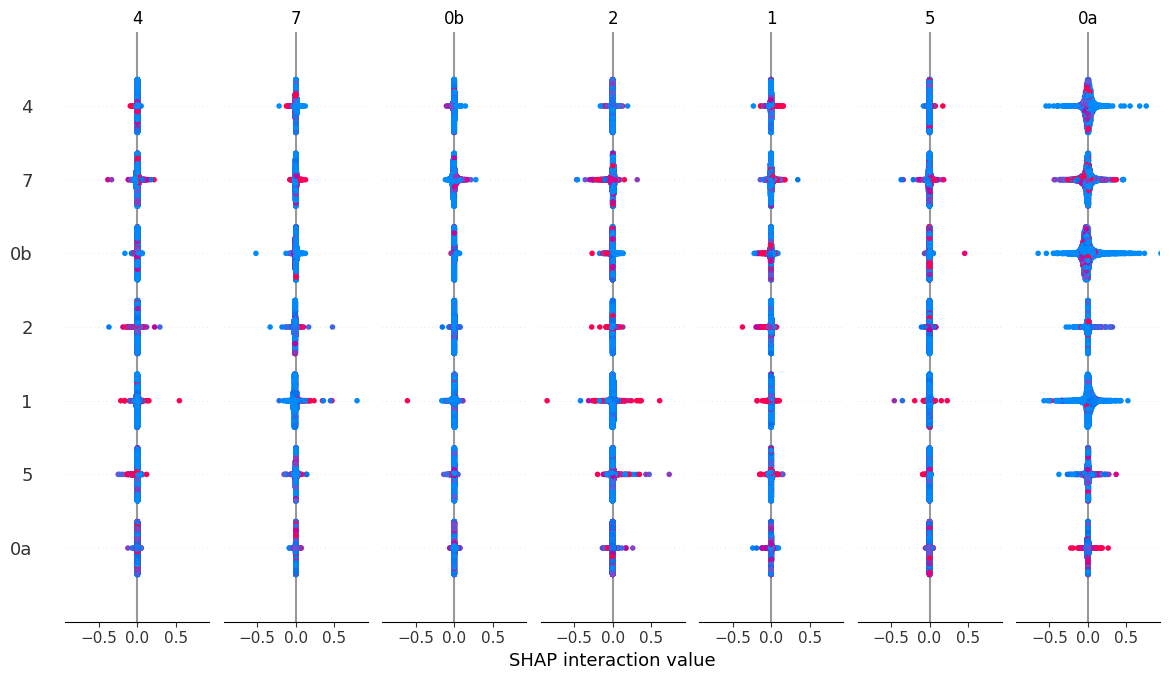

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

plt.show()

In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load a sample dataset (Iris dataset)
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a neural network model (you can replace this with your own model)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes for Iris dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, verbose=0)

# Initialize the SHAP explainer with a higher max_evals value
explainer = shap.Explainer(model, X_train, algorithm="permutation", max_evals=1000)

# Get SHAP values for all samples in the test set
shap_values = explainer.shap_values(X_test)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)  # Use shap_values[0] for the first class

# Sort and print the top 10 features that negatively impact the model
sorted_feature_importances = sorted(enumerate(mean_abs_shap_values), key=lambda x: x[1], reverse=True)
top_10_negative_features = sorted_feature_importances[:10]

print("Top 10 Features with Negative Impact on the Model:")
for feature_idx, importance in top_10_negative_features:
    print(f"Feature {feature_idx} - {importance:.4f}")



Top 10 Features with Negative Impact on the Model:
Feature 1 - 0.1329
Feature 0 - 0.0861
Feature 2 - 0.0676
